<div style=float:right><img src="assets/img/applied-logo_100px.png"></img></div>

#### Applied AI Internal Demo Project
## Survival Analysis HDD

Demo some capabilities of parametric and nonparametric survival analysis using Python tools.  
Using hard drive survival data from the [BackBlaze HDD tests](https://www.backblaze.com/blog/hard-drive-data-feb2015/)


# 02_BasicKaplanMeierModel

+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Data](#Load-Data)


+ [Prepare Data for Modelling](#Prepare-Data-for-Modelling)
    + [Initial Descriptive Analysis](Initial-Descriptive-Analysis)
    
    
+ [Inital Modelling](#Inital-Modelling)
    + [Kaplan Meier Model](#Kaplan-Meier-Model)
    + [Nelson Aalen Model](#Nelson-Aalen-Model)
    




# Setup

In [1]:
## Interactive magics - comment out if running from another script
%matplotlib inline
%qtconsole --colors=linux --ConsoleWidget.font_size=12 --ConsoleWidget.font_family='Consolas'

In [2]:
from __future__ import division, print_function
from collections import OrderedDict
import sqlite3
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import patsy as pt
import seaborn as sns
from sklearn.cross_validation import StratifiedShuffleSplit
import triangle

import lifelines as sa
from lifelines.utils import concordance_index, k_fold_cross_validation

from IPython.html.widgets import interactive, fixed

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set default styles for plotting via pandas, seaborn and matplotlib
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
sns.set(style='darkgrid')
cmap_clrbld = ['#777777','#E69F00','#56B4E9','#D3C511'
               ,'#009E73','#8D42F0','#0072B2','#D55E00','#CC79A7']
plt.rcParams['axes.color_cycle'] = cmap_clrbld
plt.rcParams['figure.figsize'] = 16, 3

np.random.seed(0)
use_prop_of_full_set = 0.25

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Local Functions

In [3]:
def standardize_fit(s):
    """ calculate and return a dict of fit params 
        for standardizing a series {mean, sd, range} """
    return {'mean': s.mean(), 'sd': s.std(), 'range': s.max() - s.min()}


def standardize_transform(s, center, denominator):
    """ transform series according to center and denominator """
    return (s - center) / denominator


def create_dmatrix_for_modelling(formula, df, predictonly=False):
    """ transform compact dataframe into expanded """
    dft = pt.dmatrix(formula, df, return_type='dataframe')
    design_info = dft.design_info
    
    if predictonly:
        return dft, design_info
    else:
        return dft.join(df[['maxhours','failed']]), design_info


## Load Data

In [5]:
cnx = sqlite3.connect('data/drive_stats.db')
df = pd.read_sql('select * from drive_survival_prepared', con=cnx
                 ,index_col='diskid', parse_dates=['mindate','maxdate'])

In [6]:
print(df.shape)
df.head()

(47252, 12)


,model,mindate,maxdate,nrecords,minhours,maxhours,failed,manufacturer,capacity,mindateym,maxdateym,ndaysduration
diskid,,,,,,,,,,,,
5XW004AJ,ST31500541AS,2013-04-20,2014-12-31,564,21697,36586,0,SEAGATE,1.5TB,201304,201412,620
5XW004Q0,ST31500541AS,2013-04-10,2014-12-31,574,29341,44471,0,SEAGATE,1.5TB,201304,201412,630
5XW008MX,ST31500541AS,2013-04-10,2014-12-31,574,29341,44471,0,SEAGATE,1.5TB,201304,201412,630
5XW00B95,ST31500541AS,2013-04-10,2014-12-31,574,26920,42049,0,SEAGATE,1.5TB,201304,201412,630
5XW00E5M,ST32000542AS,2013-05-16,2014-07-31,386,22036,32614,0,SEAGATE,2.0TB,201305,201407,441


In [7]:
df.dtypes

model                    object
mindate          datetime64[ns]
maxdate          datetime64[ns]
nrecords                  int64
minhours                  int64
maxhours                  int64
failed                    int64
manufacturer             object
capacity                 object
mindateym                object
maxdateym                object
ndaysduration           float64
dtype: object

---

# Prepare Data For Modelling

##### Subselect rows for interactive model dev

In [8]:
if (use_prop_of_full_set > 0) & (use_prop_of_full_set < 1):

    kfold_shuffle0 = StratifiedShuffleSplit(y=df['failed'].values, n_iter=1, test_size=(1 - use_prop_of_full_set), random_state=0)

    for retained_idx, removed_idx in kfold_shuffle0:
        dfi = df.iloc[retained_idx].copy()
        break

dfi = dfi.sort_index()    
print(dfi.shape)

(11813, 12)


##### Select separate train & test sets for when we're not using the lifelines kfold method

In [16]:
kfold_shuffle1 = StratifiedShuffleSplit(y=dfi['failed'].values, n_iter=1, test_size=0.2, random_state=0)

for train_idx, test_idx in kfold_shuffle1:
    dfi_train = dfi.iloc[train_idx].sort_index()
    dfi_test = dfi.iloc[test_idx].sort_index()

print('train: {}, test: {}'.format(dfi_train.shape, dfi_test.shape))

train: (9450, 13), test: (2363, 13)


##### Declare universe of feats available for use

In [9]:
feats_factor = ['manufacturer', 'model', 'capacity']
feats_numeric = ['maxhours']
feats_numeric2sd = ['{}2sd'.format(f) for f in feats_numeric]

##### Standardize numeric feats

In [18]:
fits_df, fits_dfi, fits_dfi_train = OrderedDict(), OrderedDict(), OrderedDict()

for f1, f2 in zip(feats_numeric, feats_numeric2sd):
    
    ## transform df
    fits_df[f1] = standardize_fit(df[f1])
    df[f2] = standardize_transform(df[f1], fits_df[f1]['mean'], 2*fits_df[f1]['sd'])

    ## transform dfi
    fits_dfi[f1] = standardize_fit(dfi[f1])
    dfi[f2] = standardize_transform(dfi[f1], fits_dfi[f1]['mean'], 2*fits_dfi[f1]['sd'])
    
    ## transform dfi train & test
    fits_dfi_train[f1] = standardize_fit(dfi_train[f1])
    dfi_train[f2] = standardize_transform(dfi_train[f1], fits_dfi_train[f1]['mean'], 2*fits_dfi_train[f1]['sd'])
    dfi_test[f2] = standardize_transform(dfi_test[f1], fits_dfi_train[f1]['mean'], 2*fits_dfi_train[f1]['sd'])

##### Quick view of numeric feats

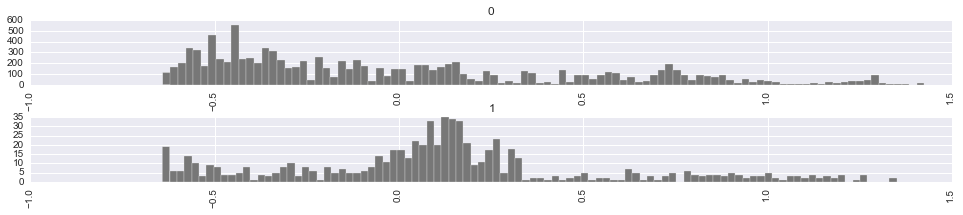

In [19]:
ax = dfi.hist(column='maxhours2sd', by='failed', bins=100, layout=(2,1))

In [ ]:
# fig = triangle.corner(dfi[feats_numeric2sd].iloc[::1,:], labels=feats_numeric2sd
#         , quantiles=[0.025, 0.5, 0.975], show_titles=True, title_args={"fontsize": 10}
#         , verbose=False, plot_ellipse=True)

---

# Inital Modelling

## Kaplan Meier Model

(0, 1)

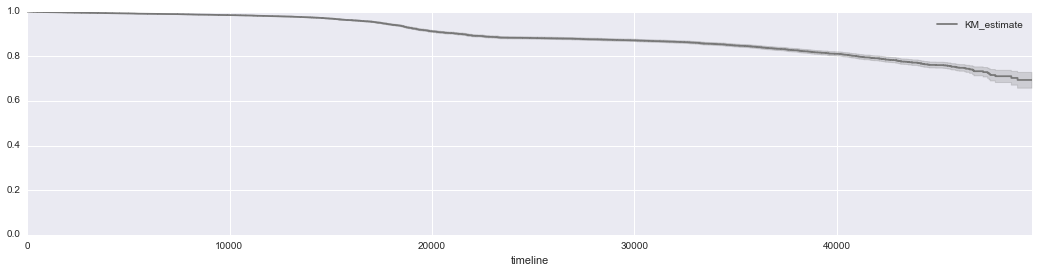

In [25]:
km = sa.KaplanMeierFitter()
km.fit(durations=df['maxhours'], event_observed=df['failed'])
ax = km.plot(figsize=(18,4))
ax.set_ylim([0,1])

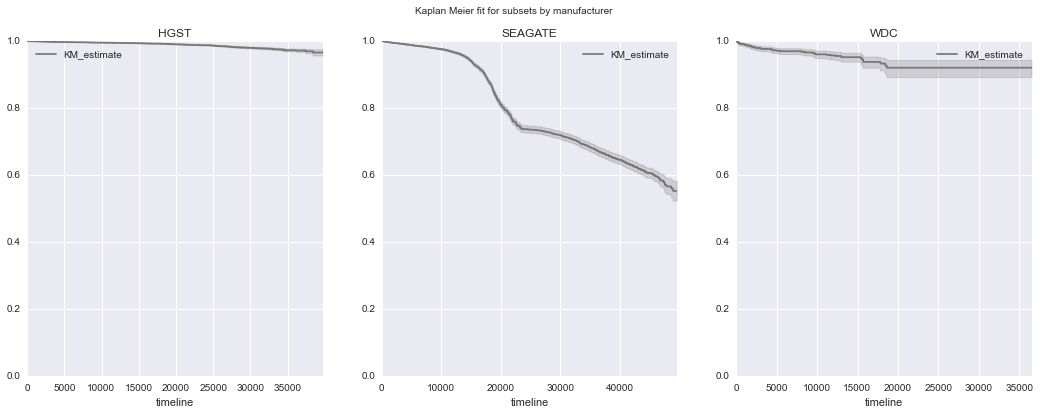

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(18,6))
fig.suptitle('Kaplan Meier fit for subsets by manufacturer')

for i, mfr in enumerate(np.unique(df['manufacturer'])):
    km = sa.KaplanMeierFitter()
    dfsub = df.loc[df['manufacturer']==mfr]
    km.fit(durations=dfsub['maxhours'], event_observed=dfsub['failed'])
    ax = km.plot(ax=axes[0,i], title=mfr)
    ax.set_ylim([0,1])

---
<div style=float:right><img src=assets/img/applied-logo_100px.png></img></div>
**&copy; Applied AI Ltd 2015**  
<a href='http://www.applied.ai'>applied.ai</a>